In [ ]:
# Run this cell to install DiffeRT and its dependencies, e.g., on Google Colab

try:
    import differt  # noqa: F401
except ImportError:
    import sys  # noqa: F401

    !{sys.executable} -m pip install differt[all]

# Sampling Path Candidates with Machine Learning

This notebook aims at being a tutorial to reproduce the results presented in the paper
*Generative Flow Sets-based $\mathrm{E}(3)$-Invariant Ray Path Sampling for Faster Point-to-Point Ray Tracing: Introduction and Concept*,
and assumes you are familiar with its content.

**You can run it locally or with Google Colab** by cliking on the rocket
at the top of this page!

:::{tip}
On Google Colab, make sure to select a GPU or TPU runtime for a faster experience.
:::

If you find this tutorial useful and plan on using this tool for your publications,
please cite our work, see {ref}`citing`.

## Summary

In our work, we present a Machine Learning (ML) model that aims at reducing the computational complexity
of exhaustive Point-to-Point (P2P) Ray Tracing (ML) by learning how to sample path candidates.
For further details, please refer to the paper.

## Imports

We need to import quite a few Python modules, but all of them should be installed with `differt[all] e3x`.

In [ ]:
from collections.abc import Iterator
from functools import partial
from typing import Any

import e3x
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from beartype import beartype as typechecker
from jaxtyping import Array, Bool, Float, Int, PRNGKeyArray, PyTree, jaxtyped
from tqdm.notebook import trange

from differt.geometry.triangle_mesh import TriangleMesh
from differt.geometry.utils import path_lengths
from differt.plotting import reuse, set_defaults
from differt.scene.sionna import download_sionna_scenes, get_sionna_scene
from differt.scene.triangle_scene import TriangleScene
from differt.utils import sample_points_in_bounding_box

## Generating Training Data

For this tutorial, we restrict ourselves to a simple urban scenario, obtained from {cite}`sionna`,
from which we will derive random scenes.

In [ ]:
download_sionna_scenes()  # Let's download Sionna scenes (from the main branch)

In [ ]:
set_defaults(
    "plotly"
)  # Our scene is simple, and Plotly is the best backend for online interactive plots :-)

use_box = False  # Set this to 'True' to work on an even simpler scene

if use_box:
    mesh = TriangleMesh.box(length=10.0, width=4.0, height=3.0)
    base_scene = TriangleScene(mesh=mesh)
else:
    file = get_sionna_scene("simple_street_canyon")
    base_scene = TriangleScene.load_xml(file)

base_scene = base_scene.set_assume_quads(True)
# Set the above to 'True' of you want to sample quadrilaterals instead of triangles
base_scene.plot()

From the `base_scene` object, we can generate random variations of it.
Two types of variations are considered here:

1. the number of objects (either triangles or quadrilaterals);
2. and the TX / RX positions.

As our model is invariant with respect to $\mathrm{E}(3)$, we do not perform any scaling, translation, or rotation
of the scene in the training dataset, but we will check that our model's output remains the same regarding
any of the above transformations.

:::{note}
Unlike with NumPy and other common array libraries,
JAX requires an explicit random key ({func}`jax.random.key`) whenever you need to generate
pseudo-random numbers. While this can lead to more verbose code, this has the
**major advantage** of making random number generation easily reproducible **straightforward**,
even across multiple devices. *You want the same results? Then just pass the same key!*
:::

In [ ]:
@eqx.filter_jit
@jaxtyped(typechecker=typechecker)
def random_tx_rx(
    base_scene: TriangleScene, *, key: PRNGKeyArray
) -> TriangleScene:
    """
    Return a random scene with one TX and one RX, at random positions.

    TX is placed in the "upper" part of the scene, and RX is the "lower" part.
    This is just to increase the chances of having possible ray paths in between,
    while maintaining relatively realistic positions.

    Args:
        base_scene: The base scene from which the random scene
            is derived.
        key: The random key to be used.

    Returns:
        A new scene.
    """
    scene = base_scene
    bounding_box = scene.mesh.bounding_box
    min_z, max_z = bounding_box[:, 2]
    rx_bounding_box = bounding_box.at[:, 2].set([min_z + 0.5, min_z + 2.0])
    rx_bounding_box = rx_bounding_box.at[:, 1].set([-5.0, +5.0])
    tx_bounding_box = bounding_box.at[:, 2].set([max_z + 5.0, max_z + -5.0])
    tx_bounding_box = tx_bounding_box.at[:, 1].set([-5.0, +5.0])
    key_tx, key_rx = jax.random.split(key, 2)
    scene = eqx.tree_at(
        lambda s: s.transmitters,
        scene,
        sample_points_in_bounding_box(tx_bounding_box, key=key_tx),
    )
    return eqx.tree_at(
        lambda s: s.receivers,
        scene,
        sample_points_in_bounding_box(rx_bounding_box, key=key_rx),
    )


@jaxtyped(typechecker=typechecker)
def random_scene(
    base_scene: TriangleScene, *, key: PRNGKeyArray
) -> TriangleScene:
    """
    Return a random scene with one TX and one RX, at random positions, and a random number of objects.

    The number of objects can be anywhere between 1 and the total number of objects in the scene.

    Args:
        base_scene: The base scene from which the random scene
            is derived.
        key: The random key to be used.

    Returns:
        A new scene.
    """
    scene = base_scene
    key_tx_rx, key_num_objects, key_sample_triangles = jax.random.split(key, 3)
    scene = random_tx_rx(scene, key=key_tx_rx)
    num_objects = scene.mesh.num_objects
    num_objects = jax.random.randint(
        key_num_objects, (), num_objects // 2, num_objects + 1
    )
    return eqx.tree_at(
        lambda s: s.mesh,
        scene,
        scene.mesh.sample(int(num_objects), key=key_sample_triangles),
    )


@jaxtyped(typechecker=typechecker)
def train_dataloader(
    base_scene: TriangleScene, num_reuse: int = 10, *, key: PRNGKeyArray
) -> Iterator[TriangleScene]:
    """
    Return an (infinite) iterator over random scenes for training the model.

    Args:
        base_scene: The base scene from which random scenes
            are derived.
        num_reuse: The number of times a random scene is reused.

            When a scene is reused, only TX / RX positions are changed.
        key: The random key to be used.

    Yields:
        An infinite number of random scenes.
    """

    while True:
        key, key_to_use = jax.random.split(key, 2)
        scene = random_scene(base_scene, key=key_to_use)

        for _ in range(num_reuse):
            key, key_to_use = jax.random.split(key, 2)
            yield random_tx_rx(scene, key=key_to_use)

        del scene

Below, we demonstrate how to generate (and plot) a random scene.

In [ ]:
key_example = jax.random.key(1234)

with reuse() as fig:
    scene = random_scene(base_scene, key=key_example)
    scene.plot(showlegend=False)

    for i in range(3):
        paths = scene.compute_paths(order=i)
        print(  # noqa: T201
            f"(order = {i}) Found {int(paths.mask.sum()):2d} valid paths our of {paths.mask.size:4d} path candidates."
        )
        paths.plot(showlegend=False)

fig

(order = 0) Found  1 valid paths our of    1 path candidates.
(order = 1) Found  1 valid paths our of   24 path candidates.
(order = 2) Found  0 valid paths our of  552 path candidates.


In [ ]:
@eqx.filter_jit
@jaxtyped(typechecker=typechecker)
def reward(
    path_candidate: Int[Array, " order"],
    scene: TriangleScene,
) -> Float[Array, " "]:
    """
    Reward a predicted path candidate depending on if it
    produces a valid path in the given scene.

    If the scene contains multiple TXs and RXs, then
    the maximum number of valid paths, i.e., 'max_valid_paths'
    is the number of TXs times the number of RXs.

    Args:
        path_candidate: The path candidate to evaluate.
        scene: The scene on which to evaluate the path candidate.

    Returns:
        A possible reward, between 0 and 'max_valid_paths'.
    """
    paths = scene.compute_paths(path_candidates=path_candidate.reshape(1, -1))

    r = 1 / path_lengths(paths.vertices)

    return jnp.where(paths.mask, r, 0.1 * r).sum()

## Machine Learning Model

Our model is made of two parts: an inner *Flow* model, take returns the flows between a parent state and its child states,
and an outer model, that extract features form the scene, and repeadly calls the *Flow* model to generate a path candidate.

### Inner *Flow* Model

This model maps multiple feature vectors into a vector of flows.

In [ ]:
class FlowModel(eqx.Module):
    """Flow model that returns flows between parent and child states."""

    cell: eqx.nn.GRUCell
    """Cell that generate a vector of features from an ordered sequence of feature vectors."""
    features_2_flow: eqx.nn.MLP
    """MLP that maps each (scene_features, object_features[i, :], state_features) to flow."""

    def __init__(
        self,
        # Hyperparameters
        num_features: int = 100,
        *,
        key: PRNGKeyArray,
    ) -> None:
        """
        Construct a GFlowNet model.

        Args:
            num_features: The size of the vector that represents each object.
            key: The random key to be used.
        """
        key_cell, key_flow = jax.random.split(key, 2)

        # 1 - Combine arbitrary many features from an (ordered) state and create a new feature vector
        self.cell = eqx.nn.GRUCell(
            input_size=num_features,
            hidden_size=num_features,
            key=key_cell,
        )

        # 2 - Features to flow
        self.features_2_flow = eqx.nn.MLP(
            # Takes scene_features + object_features[i, :] + state_features
            in_size=num_features * 3,
            out_size="scalar",
            width_size=500,
            depth=3,
            final_activation=jnp.exp,  # Positive flow only
            key=key_flow,
        )

    @eqx.filter_jit
    @jaxtyped(typechecker=typechecker)
    def __call__(
        self,
        scene_features: Float[Array, " num_features"],
        object_features: Float[Array, "num_objects num_features"],
        state: Bool[Array, "order num_objects"],
    ) -> Float[Array, " num_objects"]:
        """
        Call this model in order to generate a new flow from a given state,
        and an abstract representation of the scene and its objects.

        Invariance with respect to E(3) should be guaranteed by the callee,
        i.e., the arguments passed to this function are treated regardless of
        any geometrical property.

        Args:
            scene_features: The vector of scene features.
            object_features: The array of each object's features.
            state: The current state, a one-hot encoding of the path candidate
                in construction. Only one element per column can be 'True'.

        Returns:
            The array of flows, one per object.
        """
        # [order num_features]
        # note: this is a simple but efficient way to take object features
        #       corresponding to object indices encoded in the state
        state_features = jnp.einsum("ij,jk->ik", state, object_features)

        # [order num_features]
        # note: we transform 'order' vectors of 'num_features' values into
        #       one vector of 'num_features' values.
        #       We could have used the 'sum' operation (over the leading axis),
        #       but then we loose information about the order in which features
        #       appeared. A cell can keep some information about ordering since
        #       cell(cell(a, b), c) isn't the same as, e.g., cell(cell(b, a), c).
        state_features = jax.lax.scan(
            lambda state, features: (self.cell(features, state), None),
            jnp.zeros_like(scene_features),
            state_features,
        )[0]

        # [num_objects]
        # note: the input (per object) looks as follows
        #       # [scene_features, state_features, object_features[i, :]]
        return jax.vmap(
            lambda *features: self.features_2_flow(jnp.concatenate(features)),
            in_axes=(None, 0, None),
        )(
            scene_features,
            object_features,
            state_features,
        )

### Outer Model

The outer (main) model is what generates a path candidate from a given scene configuration
and a random key.

In [ ]:
import flax.linen as nn


class FlaxE3MLP(nn.Module):
    """Convert xyz-triples into a features fectors while preserving rotation invariance."""

    num_features: int
    max_degree: int = 2

    @nn.compact
    def __call__(
        self, xyz: Float[Array, "num_points 3"]
    ) -> Float[Array, "num_points num_features"]:
        # [num_points 1 (max_degree+1)**2 num_features]
        x = e3x.nn.basis(
            xyz,
            num=self.num_features,
            max_degree=self.max_degree,
            radial_fn=partial(e3x.nn.triangular_window, limit=2.0),
        )
        # [num_points 2 (max_degree+1)**2 num_features]
        x = e3x.nn.TensorDense()(x)
        # [num_points 2 1 num_features]
        x = e3x.nn.TensorDense(max_degree=0)(x)
        # [num_points 2*num_features]
        x = x.reshape(x.shape[0], -1)

        return nn.Dense(features=self.num_features)(x)


class E3MLP(eqx.Module):
    """Convenient Equinox wrapper to use Flax's modules."""

    params: PyTree[Array]
    flax_model: FlaxE3MLP = eqx.field(static=True)

    def __init__(self, *args: Any, key: PRNGKeyArray, **kwargs: Any) -> None:
        self.flax_model = FlaxE3MLP(*args, **kwargs)
        # TODO: see if we can do something else than providing a dummy 'xyz' input
        self.params = self.flax_model.init(key, jnp.empty((3, 3)))

    @eqx.filter_jit
    @jaxtyped(typechecker=typechecker)
    def __call__(
        self, xyz: Float[Array, "num_points 3"]
    ) -> Float[Array, "num_points num_features"]:
        return self.flax_model.apply(self.params, xyz)


class Model(eqx.Module):
    """Generative model that samples a path candidate from flows."""

    xyz_2_features: E3MLP
    """MLP that maps xyz coordinates to a larger rotation-equivariant features vector."""
    flow: FlowModel
    """Flow model."""
    inference: bool
    """Whether this model is used for training or inference."""

    def __init__(
        self,
        # Hyperparameters
        num_features: int = 100,
        *,
        inference: bool = False,
        key: PRNGKeyArray,
    ) -> None:
        """
        Construct a model.

        Args:
            num_features: The size of the vector that will represent each xyz triplet.
            key: The random key to be used.
        """
        self.inference = inference

        key_embeds, key_flow = jax.random.split(key, 2)

        # Layers

        # 1 - World coordinates to features
        self.xyz_2_features = E3MLP(num_features=num_features, key=key_embeds)

        # 2 - Generate flow
        self.flow = FlowModel(
            num_features=num_features,
            key=key_flow,
        )

    @eqx.filter_jit
    @jaxtyped(typechecker=typechecker)
    def __call__(
        self,
        scene: TriangleScene,
        *,
        order: int,
        key: PRNGKeyArray,
    ) -> (
        Int[Array, " {order}"]
        | tuple[Int[Array, " {order}"], Float[Array, "{order} num_objects"]]
    ):
        """
        Call this model to generate a path candidate of the given order.

        Args:
            scene: The triangle scene.
            order: The order of the path candidate.
            key: The random key to be used.

        Returns:
            A path candidate.

            If training mode, it also returns the array of flows.
        """
        # 1 - Extracting data

        num_objects = scene.mesh.num_objects
        num_triangles = scene.mesh.num_triangles

        tx = scene.transmitters.reshape(-1, 3)
        num_tx = tx.shape[0]
        rx = scene.receivers.reshape(-1, 3)
        num_rx = rx.shape[0]
        flat_tri = scene.mesh.triangle_vertices.reshape(-1, 3)

        # [num_tx+num_rx+3*num_triangles 3]
        xyz = jnp.concatenate((tx, rx, flat_tri), axis=0)

        # 2 -  Computing features

        # [num_tx+num_rx+num_triangles num_features]
        xyz -= jnp.mean(xyz, axis=0, keepdims=True)
        xyz /= jnp.std(xyz, axis=0, keepdims=True)
        xyz_features = self.xyz_2_features(xyz)

        # [num_features]
        scene_features = xyz_features.sum(axis=0)

        # [num_triangles num_features]
        tri_features = (
            # [num_triangles*3 num_features]
            xyz_features[num_tx + num_rx :, ...]
            # [num_triangles 3 num_features]
            .reshape(num_triangles, 3, *xyz_features.shape[1:])
            .mean(axis=1)
        )

        # [num_objects num_features]
        # note: this is a no-op is 'scene.mesh.assume_quads' is False
        object_features = tri_features.reshape(
            num_objects, -1, *tri_features.shape[1:]
        ).sum(axis=1)

        # 3 - Generating path candidates

        ScanR = Int[Array, " "]
        Flow = Float[Array, f" {num_objects}"]
        State = Bool[Array, f"{order} {num_objects}"]
        ScanC = tuple[
            Flow,
            State,
        ]

        if not self.inference:  # During training, we return the flows
            ScanR = tuple[ScanR, Flow]

        @jaxtyped(typechecker=typechecker)
        def scan_fn(
            carry: ScanC,
            key_and_current_order: tuple[PRNGKeyArray, Int[Array, " "]],
        ) -> tuple[ScanC, ScanR]:
            parent_edge_flow_prediction, state = carry
            key, current_order = key_and_current_order

            # Randomly choose a child state (i.e., an object), based on forward flow
            p = parent_edge_flow_prediction / parent_edge_flow_prediction.sum()
            object_index = jax.random.categorical(key=key, logits=jnp.log(p))

            # Update 'state' accordingly
            state = state.at[current_order, object_index].set(True)

            # Compute the new flow, and stop any flow to 'object_index'
            # to avoid sampling the sample object twice in a row
            edge_flow_prediction = (
                self.flow(scene_features, object_features, state)
                .at[object_index]
                .set(0.0)
            )

            if self.inference:
                return (edge_flow_prediction, state), object_index
            return (edge_flow_prediction, state), (
                object_index,
                edge_flow_prediction,
            )

        # Let's initialize the variables
        state = jnp.zeros((order, num_objects), dtype=bool)
        parent_edge_flow_prediction = self.flow(
            scene_features, object_features, state
        )

        # We use scan to efficiently loop over multiple states
        init = parent_edge_flow_prediction, state
        _, path_candidate = jax.lax.scan(
            scan_fn,
            init,
            xs=(jax.random.split(key, order), jnp.arange(order)),
        )

        if not self.inference:
            path_candidate, flows = path_candidate
            flows = jnp.vstack((parent_edge_flow_prediction, flows[1:, :]))

        if scene.mesh.assume_quads:
            path_candidate *= 2

        if not self.inference:
            return path_candidate, flows

        return path_candidate

    @eqx.filter_jit
    @jaxtyped(typechecker=typechecker)
    def sample_path_candidates(
        self,
        *args: Any,
        num_path_candidates: int,
        order: int,
        key: PRNGKeyArray,
        **kwargs: Any,
    ) -> Int[Array, "{num_path_candidates} {order}"]:
        """
        Sample 'num_path_candidates' in a given scene.

        This is a convenient wrapper samples arbitrary many path candidates,
        and has the same output in both training and inference modes.

        Args:
            args: Positional arguments passed to :meth:`__call__`.
            order: The order of the path candidate.
            key: The random key to be used.
            kwargs: Keyword arguments passed to :meth:`__call__`.

        Returns:
            An array of path candidate.
        """

        @jaxtyped(typechecker=typechecker)
        def scan_fun(
            _: None, key: PRNGKeyArray
        ) -> tuple[None, Int[Array, f" {order}"]]:
            path_candidate = self(*args, order=order, key=key, **kwargs)

            if self.inference:
                return None, path_candidate

            return None, path_candidate[0]

        return jax.lax.scan(
            scan_fun,
            init=None,
            xs=jax.random.split(key, num_path_candidates),
        )[1]

### Loss Function

Essential to any ML task, the loss function must reflect how well the model is learning.

We define our loss function to closely follows that of *GFlowNet* models: the goal
is to have a matching between a giving parent flow at a state $s$ and the sum of the flows of all
its child states $s'$, where the last child state is replaced by the reward of the corresponding path candidate.

In [ ]:
@eqx.filter_jit(donate="all-except-first")
@jaxtyped(typechecker=typechecker)
def loss(
    model: Model,
    scene: TriangleScene,
    num_path_candidates: int = 50,
    *,
    order: int,
    key: PRNGKeyArray,
) -> Float[Array, " "]:
    """
    Compute the loss of the model on a specific input scene.

    The loss is accumulated over the generation of many path candidates.

    Args:
        model: The model to evaluate.
        scene: The scene on which to evaluate the model.

            This argument is 'donated', i.e.,
            it cannot be used after calling this function.
        num_path_candidates: The number of path candidates that will be
            generated to compute the loss.
        order: The order of the path candidate.
        key: The random key to be used.

    Returns:
        The loss, accumulated over multiple path candidates.
    """
    assert (
        not model.inference
    ), "Model cannot estimate loss in 'inference' mode."
    assert (
        num_path_candidates > 0
    ), "Number of path candidates must be greater than zero."

    @jaxtyped(typechecker=typechecker)
    def compute_loss(key: PRNGKeyArray, order: int) -> Float[Array, " "]:
        path_candidate, flows = model(scene, order=order, key=key)
        r = reward(path_candidate, scene)

        if scene.mesh.assume_quads:
            object_indices = path_candidate // 2
        else:
            object_indices = path_candidate

        # [order]
        parent_flows = jnp.take_along_axis(
            flows, object_indices.reshape(-1, 1), axis=1
        )
        # [order-1]
        sum_edge_flows = flows[1:, :].sum(axis=-1)
        sum_edge_flows = jnp.append(sum_edge_flows, r)

        return ((parent_flows - sum_edge_flows) ** 2.0).sum()

    @jaxtyped(typechecker=typechecker)
    def scan_path_candidates(
        carry_loss: Float[Array, " "],
        key: PRNGKeyArray,
    ) -> tuple[Float[Array, " "], None]:
        return carry_loss + compute_loss(key, order), None

    carry_loss, _ = jax.lax.scan(
        scan_path_candidates,
        jnp.array(0.0),
        xs=jax.random.split(key, num_path_candidates),
    )

    return carry_loss

In [ ]:
def train(
    model: Model,
    train_samples: Iterator[TriangleScene],
    optim: optax.GradientTransformation,
    steps: int = 10_000,
    print_every: int = 100,
    *,
    order: int,
    key: PRNGKeyArray,
) -> tuple[Model, Float[Array, " steps"]]:
    """
    Train a model on a sequence of training samples and returns the training loss average of samples.

    Args:
        model: The model to train.
        train_samples: The training samples.
        steps: The number of training steps.
        print_every: The frequency at which the train loss is displayed.
        order: The order of the path candidate.
        key: The random key to be used.

    Returns:
        The trained model and the array of train losses.
    """
    opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

    @eqx.filter_jit(donate="all")
    def make_step(
        model: Model,
        opt_state: optax.OptState,
        scene: TriangleScene,
        *,
        key: PRNGKeyArray,
    ) -> tuple[Model, optax.OptState, Float[Array, " "]]:
        loss_value, grads = eqx.filter_value_and_grad(loss)(
            model,
            scene,
            order=order,
            key=key,
        )
        updates, opt_state = optim.update(
            grads, opt_state, eqx.filter(model, eqx.is_array)
        )
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    train_losses = []

    print_width = len(str(steps))

    with trange(steps, desc="", unit=" steps", leave=True) as bar:
        for (
            step,
            scene,
        ) in zip(bar, train_samples, strict=False):
            key, key_step = jax.random.split(key, 2)

            model, opt_state, train_loss = make_step(
                model, opt_state, scene, key=key_step
            )
            train_losses.append(train_loss)

            if (step % print_every) == 0 or (step == steps - 1):
                bar.set_description(
                    f"Train loss @ iter. #{step:0{print_width}d} is {float(train_loss):.1e}"
                )

    return model, jnp.array(train_losses)

In [ ]:
key_train = jax.random.key(1234)
key_model, key_train_model, key_train_samples = jax.random.split(key_train, 3)

untrained_model = Model(key=key_model)
train_samples = train_dataloader(base_scene, key=key_train_samples)
optim = optax.adam(learning_rate=3e-5)

trained_model, train_losses = train(
    untrained_model, train_samples, optim, order=2, key=key_train_model
)

  0%|          | 0/10000 [00:00<?, ? steps/s]

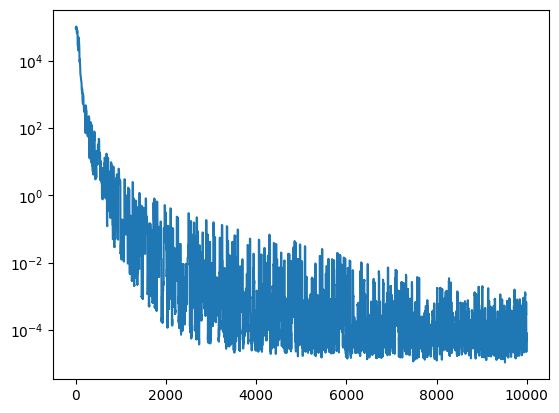

In [ ]:
plt.semilogy(train_losses);

In [ ]:
key_eval_trained = jax.random.key(123)

key_sample_trained, key_eval_scene = jax.random.split(key_eval_trained, 2)

with reuse() as fig:
    scene = random_scene(base_scene, key=key_eval_scene)
    scene.plot()

    path_candidates = trained_model.sample_path_candidates(
        scene, order=2, num_path_candidates=30, key=key_sample_trained
    )
    paths = scene.compute_paths(path_candidates=path_candidates)
    paths.plot()

fig

### Checking $\mathrm{E}(3)$-Invariance

In the cell, we check that our model outputs the same, regardless of the rotation of the scene.

In [ ]:
key_test_e3 = jax.random.key(1234)
key_rotation, key_sample = jax.random.split(key_test_e3)

rotation = e3x.so3.random_rotation(key_rotation)
rotated_scene = base_scene.rotate(rotation)
rotated_scene.plot()

In [ ]:
print(  # noqa: T201
    "Base scene prediction:\n",
    trained_model.sample_path_candidates(
        base_scene, order=2, num_path_candidates=10, key=key_sample
    ).tolist(),
)
print(  # noqa: T201
    "Rotated scene prediction:\n",
    trained_model.sample_path_candidates(
        rotated_scene, order=2, num_path_candidates=10, key=key_sample
    ).tolist(),
)

Base scene prediction:
 [[8, 70], [14, 12], [54, 64], [32, 44], [64, 70], [50, 48], [14, 12], [52, 44], [24, 6], [24, 18]]
Rotated scene prediction:
 [[8, 70], [14, 12], [54, 64], [32, 44], [64, 70], [50, 48], [14, 12], [52, 44], [24, 6], [24, 18]]


In [ ]:
print(  # noqa: T201
    "Base scene flows:\n",
    trained_model(base_scene, order=2, key=key_sample)[1],
)
print(  # noqa: T201
    "Rotated scene flows:\n",
    trained_model(rotated_scene, order=2, key=key_sample)[1],
)

Base scene flows:
 [[1.00572329e-07 1.00572720e-07 1.00573487e-07 1.00575406e-07
  1.00572528e-07 1.00575406e-07 1.00568499e-07 1.00570418e-07
  1.00569267e-07 1.00566965e-07 1.00559866e-07 1.00577708e-07
  1.00566773e-07 1.00570610e-07 1.00567732e-07 1.00563518e-07
  1.00565821e-07 1.00568116e-07 1.00564854e-07 1.00569459e-07
  1.00566581e-07 1.00561977e-07 1.00553535e-07 1.00577900e-07
  1.00573871e-07 1.00571377e-07 1.00568499e-07 1.00570993e-07
  1.00570418e-07 1.00571953e-07 1.00573487e-07 1.00573871e-07
  1.00574255e-07 1.00574447e-07 1.00575406e-07 1.00572720e-07
  1.00578092e-07]
 [9.74167094e-08 9.74172707e-08 9.74182015e-08 9.74198784e-08
  9.74170860e-08 9.74198784e-08 9.74131851e-08 9.74152314e-08
  9.74137393e-08 9.74115153e-08 9.74048220e-08 9.74219176e-08
  9.74115153e-08 9.74152314e-08 9.74126237e-08 9.74081615e-08
  9.74105774e-08 9.74128085e-08 9.74098384e-08 9.74141159e-08
  9.74115153e-08 9.74070531e-08 9.73986900e-08 9.74222942e-08
  9.74182015e-08 9.74159704e-08 9